In [ ]:
# https://github.com/haarnoja/sac
import argparse
import datetime
import gym
import numpy as np
import itertools
import torch
from sac import SAC
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from replay_memory import ReplayMemory

In [ ]:

class arguments():
    def __init__(self):
        self.env_name = "MountainCarContinuous-v0"
        self.policy = "Gaussian"
        self.gamma = 0.99
        self.tau=0.005
        self.lr = 0.0003
        self.alpha = 0.2
        self.automatic_entropy_tuning = False
        self.seed=123456
        self.batch_size=64
        self.num_steps=100000
        self.hidden_size=256
        self.updates_per_step=1
        self.start_steps=30000
        self.target_update_interval=1
        self.replay_size = 100000
        self.cuda = False
        self.eval = True #Returns Average over 10 episodes


args = arguments()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make(args.env_name)
env.reset(seed = args.seed)
env.action_space.seed(args.seed)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print(env.action_space.sample())
print(env.reset())

[0.2730275]
[-0.5230377  0.       ]


In [ ]:
agent = SAC(env.observation_space.shape[0], env.action_space, args)

num_inputs: 2
action_space.shape[0]: (1,)
args.hidden_size: 256


In [ ]:
#Tensorboard
writer = SummaryWriter('runs/{}_SAC_{}_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), args.env_name,
                                                             args.policy, "autotune" if args.automatic_entropy_tuning else ""))

# Memory
memory = ReplayMemory(args.replay_size, args.seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(env._max_episode_steps)

999


In [ ]:
# Training Loop
total_numsteps = 0
updates = 0
policy_losses = []
rewards =[]

for i_episode in itertools.count(1):
    #print(f'episode: {i_episode}')
    episode_reward = 0
    episode_steps = 0
    done = False
    state = env.reset()

    while not done:
        #print(f'total_numsteps: {total_numsteps}')
        #print(f'episode_steps: {episode_steps}')
        if args.start_steps > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            #print("policy following")
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > args.batch_size:
            # Number of updates per step in environment
            for i in range(args.updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, args.batch_size, updates)
                policy_losses.append(policy_loss)

                writer.add_scalar('loss/critic_1', critic_1_loss, updates)
                writer.add_scalar('loss/critic_2', critic_2_loss, updates)
                writer.add_scalar('loss/policy', policy_loss, updates)
                writer.add_scalar('loss/entropy_loss', ent_loss, updates)
                writer.add_scalar('entropy_temprature/alpha', alpha, updates)
                updates += 1

        next_state, reward, done, _ = env.step(action) # Step deprecated version

        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward


        # Ignore the "done" signal if it comes from hitting the time horizon.
        # (https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py)
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    if total_numsteps > args.num_steps:
        break

    #print('a')
    writer.add_scalar('reward/train', episode_reward, i_episode)
    rewards.append(episode_reward)
    print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {}".format(i_episode, total_numsteps, episode_steps, round(episode_reward, 2)))
    #print('b')

    if i_episode % 10 == 0 and args.eval is True:
        avg_reward = 0.
        episodes = 10
        for _  in range(episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.select_action(state, evaluate=True)

                next_state, reward, done, _ = env.step(action)
                episode_reward += reward


                state = next_state
            avg_reward += episode_reward
        avg_reward /= episodes


        writer.add_scalar('avg_reward/test', avg_reward, i_episode)

        print("----------------------------------------")
        print("Test Episodes: {}, Avg. Reward: {}".format(episodes, round(avg_reward, 2)))
        print("----------------------------------------")

env.close()


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, total numsteps: 999, episode steps: 999, reward: -33.16
Episode: 2, total numsteps: 1998, episode steps: 999, reward: -32.78
Episode: 3, total numsteps: 2997, episode steps: 999, reward: -35.29
Episode: 4, total numsteps: 3996, episode steps: 999, reward: -32.28
Episode: 5, total numsteps: 4995, episode steps: 999, reward: -33.41
Episode: 6, total numsteps: 5994, episode steps: 999, reward: -32.45
Episode: 7, total numsteps: 6993, episode steps: 999, reward: -33.84
Episode: 8, total numsteps: 7992, episode steps: 999, reward: -33.35
Episode: 9, total numsteps: 8991, episode steps: 999, reward: -33.21
Episode: 10, total numsteps: 9990, episode steps: 999, reward: -33.0
----------------------------------------
Test Episodes: 10, Avg. Reward: -0.05
----------------------------------------
Episode: 11, total numsteps: 10989, episode steps: 999, reward: -34.89
Episode: 12, total numsteps: 11988, episode steps: 999, reward: -35.21
Episode: 13, total numsteps: 12987, episode steps

KeyboardInterrupt: 

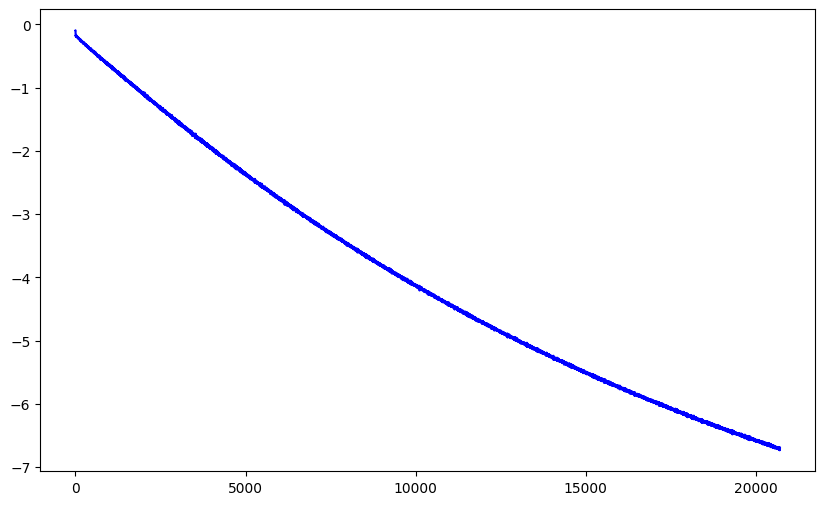

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 6))
# Plot critic losses
plt.plot(policy_losses, label='Policy Loss', color='blue')


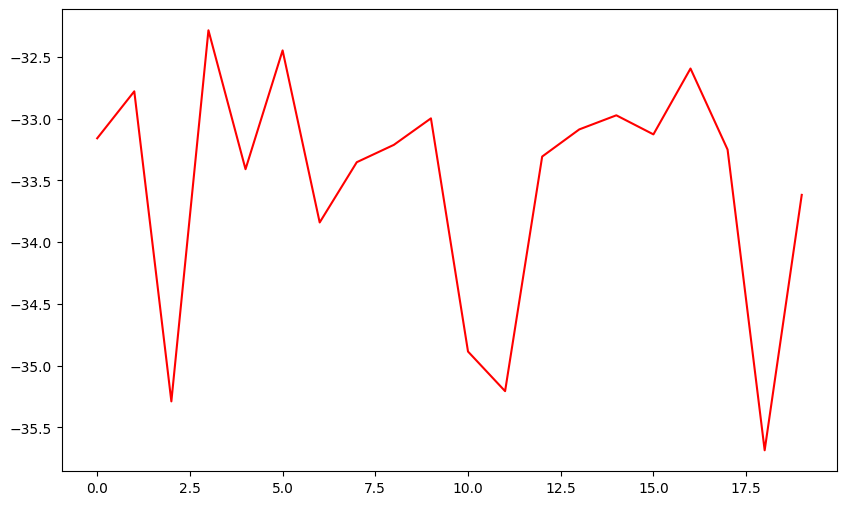

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 6))
# Plot critic losses
plt.plot(rewards, label='Reward', color='red')
